# Multi-Layer Perceptron and Gradient Descent

In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier
import sklearn.metrics

from tensorflow import keras
import requests

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
dataset_URL = "https://raw.githubusercontent.com/tufts-ml-courses/cs135-23f-assignments/main/hw3/data_flower/"

In [4]:
url = dataset_URL + "x_test.csv"
c = pd.read_csv(url, on_bad_lines='skip')

## 데이터 분포 확인

In [5]:
# Load training data
train_input = pd.read_csv(dataset_URL + 'x_train.csv', skiprows=1, delimiter=',').to_numpy()
train_target = pd.read_csv(dataset_URL + 'y_train.csv', skiprows=1, delimiter=',').to_numpy()

# Load test data
test_input = pd.read_csv(dataset_URL + 'x_test.csv', skiprows=1, delimiter=',').to_numpy()
test_target = pd.read_csv(dataset_URL + 'y_test.csv', skiprows=1, delimiter=',').to_numpy()

assert train_input.shape[0] == train_target.shape[0]
assert test_input.shape[0] == test_target.shape[0]

train_target = train_target.flatten()
test_target = test_target.flatten()

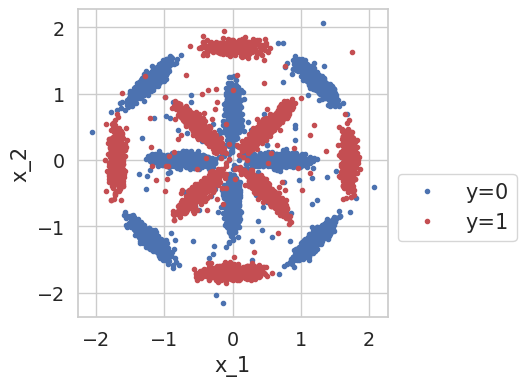

In [6]:
fig, _ = plt.subplots(figsize=(4,4));
plt.plot(train_input[(train_target == 0).flatten(), 0], train_input[(train_target == 0).flatten(), 1], 'b.', label='y=0');
plt.plot(train_input[(train_target == 1).flatten(), 0], train_input[(train_target == 1).flatten(), 1], 'r.', label='y=1');
plt.legend(bbox_to_anchor=[1.0, 0.5], fontsize=15);
plt.xlabel('x_1'); plt.ylabel('x_2');

## Explanation of codes.
**backprop_module**

우선 역전파를 위해 각 기본 연산마다 미분 값을 계산하기 위한 모듈을 만들었습니다. 각 모듈은 backprop_module 추상 클래스를 상속받아 생성됩니다. 위쪽에서 넘어온 값을 바탕으로 연쇄적으로 미분값을 계산하기 위해 upstream 값을 인수로 받아 이를 통해 downstream 미분 값을 계산합니다. 이들 모듈은 predict과정에서 계산된 x,y를 저장해둔뒤, 이를 backward 과정에서 사용하도록 설계되었습니다.

**grad_graph**

위에서 만든 모듈을 바탕으로 predict과정을 반대 방향으로 순차적으로 이동하면서 backward를 계산하는 클래스입니다.

**binary_crossentropy**

손실함수 계산 및 역전파 수행을 위한 클래스입니다. 학습과정에서 criterioin.loss()를 실행시켜 loss를 계산하고, self.loss_에 저장합니다. 이후 역전파 수행을 위해 자기 자신의 인스턴스를 반환하도록 합니다. 실제 loss 값은 이후 loss.item() 메소드로 얻을 수 있습니다.

loss 계산 후, 역전파를 수행하기 위해, loss.backward()를 수행합니다. 실행되면, predict과정에서 저장해두었던 x,y 값들을 기반으로 grad_graph에 저장된 순서의 반대 방향으로 체인룰에 의한 미분값이 계산됩니다.

이때 고민을 많이한 부분은 곱셈과 덧셈 연산을 수행하게 되면, 반대방향으로 가면 분기를 하게 되는데 현재 grad_graph는 일차원 배열에 그 순서를 저장하기 때문에 분기를 구현할 수 없는 상황이었습니다. 이를 해결하기 위해, 약간의 트릭을 적용하였습니다. self.g.operation 시 항상 y부분이 weight이므로 dl/dy 계산 결과를 따로 모아두고 이후 해당 값들로 gradient descent를 수행하는 아이디어입니다. 이때 담아둔 순서는 원래의 레이어 순서와 반대이므로 반대로 뒤집어서 반환하도록 했습니다.

또 문제가 된 것은, loss 함수로 부터 grad를 계산할 때, batch 크기로 나눠주지 않으면, 학습이 제대로 되지 않는 것이었습니다. backprop_module로부터 하위 레이어로 그래디언트 계산 시 배치 별 합산 그래디언트가 전달되므로 이를 배치크기로 나눠주지 않으면 그래디언트가 폭발하여 학습이 잘 되지 않는 문제가 발생했습니다. 따라서 이를 발견하고 배치크기로 나눠주어 문제를 해결했습니다.

**eval_mode와 train_mode**

eval_mode, train_mode 메서드를 만들어 그래프에 흐름을 저장할지 안할지를 결정하도록했습니다. 단순히 결과를 뽑는 evaluation 과정에서 연산 흐름을 저장하면, 불필요한 흐름을 저장하는 것이기 때문입니다.

**SGD**

SGD는 배치 단위 별로 그래디언트 계산 후 gradient descent를 수행하는 것이라 따로 클래스를 만들어 구현하지 않고, 바로 train 메서드에 구현하였습니다.


In [7]:
import numpy as np
from abc import ABC, abstractmethod

class backprop_module(ABC):
  def __init__(self):
    self.x = None
    self.y = None
  @abstractmethod
  def forward(self, x, y):
    pass
  @abstractmethod
  def backward(self, upstream):
    pass

class multiply(backprop_module):
  def forward(self, x, y):
    self.x = x
    self.y = y
    return np.matmul(x,y)
  def backward(self, upstream):
    # print('multiply')
    return np.matmul(upstream, np.transpose(self.y)), np.matmul(np.transpose(self.x), upstream)

class add(backprop_module):
  def forward(self, x, y):
    self.x = x
    self.y = y
    return x+y
  def backward(self, upstream):
    # print('add')
    return upstream, upstream

class relu(backprop_module):
  def forward(self, x, y=None):
    self.x = x
    return np.maximum(0, x)
  def backward(self, upstream):
    grad_input = upstream.copy()
    grad_input[self.x <= 0] = 0
    # print('relu')
    return grad_input

class sigmoid(backprop_module):
  def forward(self, x, y=None):
    self.x = x
    self.y = 1/(1+np.exp(-x))
    return self.y
  def backward(self, upstream):
    s = self.y*(1-self.y)
    # print('sigmoid')
    return s*upstream

In [8]:
class grad_graph():
  def __init__(self):
    self.graph = []
    self.grads_w = []
  def zero_grad(self):
    self.graph.clear()
  def operation(self, op, x, y=None, is_save=True):
    output = op.forward(x,y)
    if is_save:
      self.graph.append((op, y))
    return output
  def backward(self, loss_grad):
    grads = loss_grad
    self.grads_w.clear()
    for op, w in reversed(self.graph):
      if w is not None:
          grads, grad_w = op.backward(grads)
          self.grads_w.append(grad_w)
      else:
          grads = op.backward(grads)

    self.grads_w.reverse()
    return grads, self.grads_w

class binary_crossentropy():
  def __init__(self, grad_graph):
    self.y_pred = None
    self.y_label = None
    self.loss_ = 0.0
    self.g = grad_graph
  def loss(self, y_pred, y_label):
    epsilon = 1e-8
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    self.y_pred = y_pred_clipped
    self.y_label = y_label.reshape(-1, 1)

    self.loss_ = -(y_label*np.log(y_pred_clipped) + (1-y_label)*np.log(1-y_pred_clipped))
    return self
  def item(self):
    return self.loss_.sum()
  def backward(self):
    grad = (self.y_pred-self.y_label)/(self.y_pred*(1-self.y_pred))
    grad = grad / self.y_label.shape[0]
    grads, grads_w = self.g.backward(grad)
    return grads, grads_w


In [9]:
## Skeleton code
from tqdm import tqdm
class flowerNet():
  def __init__(self, input_size, num_classes):
    self.save_graph = True
    self.layer1 = np.random.randn(input_size, 16)
    self.b1 = np.random.randn(16)
    self.layer2 = np.random.randn(16, 32)
    self.b2 = np.random.randn(32)
    self.layer3 = np.random.randn(32, 16)
    self.b3 = np.random.randn(16)

    if num_classes == 2:
      self.layer4 = np.random.randn(16, 1)
      self.b4 = np.random.randn(1)
    else:
      self.layer4 = np.random.randn(16, num_classes)
      self.b4 = np.random.randn(num_classes)

    self.model_seq = [self.layer1, self.b1, self.layer2, self.b2, self.layer3, self.b3, self.layer4, self.b4]
    self.g = grad_graph()
  def eval_mode(self):
    self.save_graph = False
  def train_mode(self):
    self.save_graph = True
  def predict(self, x):
    x = self.g.operation(multiply(), x, self.layer1, self.save_graph)
    x = self.g.operation(add(), x, self.b1, self.save_graph)
    x = self.g.operation(relu(), x, None, self.save_graph)

    x = self.g.operation(multiply(), x, self.layer2, self.save_graph)
    x = self.g.operation(add(), x, self.b2, self.save_graph)
    x = self.g.operation(relu(), x, None, self.save_graph)

    x = self.g.operation(multiply(), x, self.layer3, self.save_graph)
    x = self.g.operation(add(), x, self.b3, self.save_graph)
    x = self.g.operation(relu(), x, None, self.save_graph)

    x = self.g.operation(multiply(), x, self.layer4, self.save_graph)
    x = self.g.operation(add(), x, self.b4, self.save_graph)
    x = self.g.operation(sigmoid(), x, None, self.save_graph)
    return x

  def get_batches(self, X, Y, batch_size, shuffle=True):
    N = X.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, N, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X[batch_indices], Y[batch_indices]

  def train(self, train_input, train_target, validation_input, validation_target, epoch=15, batch_size=32, lr=0.05, loss='binary_crossentropy', metrics='accuracy', optimizer='SGD'):
    # train
    # loss 정의
    if loss == 'binary_crossentropy':
      criterion = binary_crossentropy(self.g)
    else:
      raise NotImplementedError()

    for epoch in range(epoch):
      self.train_mode()
      for x_batch, y_batch in self.get_batches(train_input, train_target, batch_size):
        self.g.zero_grad()
        y_pred = self.predict(x_batch)
        # loss 계산 및 역전파
        loss = criterion.loss(y_pred, y_batch)
        _, grads = loss.backward()
        for i in range(len(self.model_seq)):
          if self.model_seq[i].ndim == 1:  # bias일 때 (1차원 배열)
            grad = grads[i].sum(axis=0)  # 배치 차원 합산
            self.model_seq[i] -= lr * grad
          else:
            # print(grads[i])
            self.model_seq[i] -= lr * grads[i]
        y_pred_int = (y_pred >= 0.5).astype(int)
        # print(f'[epoch {epoch}] Loss: {loss.item():.4f} Acc: {(y_pred_int.flatten()==y_batch).sum()/len(x_batch):.4f}')
      # test 예측 및 loss 계산
      self.eval_mode()
      print(f'[epoch {epoch}] Validation')
      total_loss = 0
      total_correct = 0
      total_samples = 0
      for test_x_batch, test_y_batch in self.get_batches(validation_input, validation_target, batch_size):
        y_pred = self.predict(test_x_batch)
        loss = criterion.loss(y_pred, test_y_batch)
        total_loss += loss.item()
        total_samples += len(test_x_batch)
        y_pred_int = (y_pred >= 0.5).astype(int)
        total_correct += (y_pred_int.flatten()==test_y_batch).sum()
      print(f'Loss: {total_loss/total_samples} Acc: {total_correct/len(validation_input):.4f}')

In [10]:
# define model
myModel = flowerNet(2, 2)

In [11]:
# accuracy before training
myModel.eval_mode()
y = myModel.predict(train_input)

print(f'Training accuracy: {np.sum((y > 0.5).flatten() == train_target) / len(train_target)}')

y = myModel.predict(test_input)
print(f'Validation accuracy: {np.sum((y > 0.5).flatten() == test_target) / len(test_target)}')

Training accuracy: 0.5622562256225623
Validation accuracy: 0.5612806403201601


In [12]:
# training example
myModel.train_mode()
myModel.train(train_input, train_target, test_input, test_target)


[epoch 0] Validation
Loss: 59.55136495343179 Acc: 0.9495
[epoch 1] Validation
Loss: 79.88686668971866 Acc: 0.9570
[epoch 2] Validation
Loss: 87.0944128282671 Acc: 0.9710
[epoch 3] Validation
Loss: 90.56970438504966 Acc: 0.9625
[epoch 4] Validation
Loss: 87.37243872082661 Acc: 0.9800
[epoch 5] Validation
Loss: 99.7913716309554 Acc: 0.9755
[epoch 6] Validation
Loss: 104.16622345341251 Acc: 0.9790
[epoch 7] Validation
Loss: 109.25201917623332 Acc: 0.9540
[epoch 8] Validation
Loss: 113.79958167823426 Acc: 0.9795
[epoch 9] Validation
Loss: 105.15424026517742 Acc: 0.9780
[epoch 10] Validation
Loss: 103.94351970464318 Acc: 0.9830
[epoch 11] Validation
Loss: 101.68462748675545 Acc: 0.9815
[epoch 12] Validation
Loss: 105.7541746164961 Acc: 0.9825
[epoch 13] Validation
Loss: 105.78722049563882 Acc: 0.9825
[epoch 14] Validation
Loss: 107.37011625768743 Acc: 0.9805


In [13]:
# accuracy after training
y = myModel.predict(train_input)

print(f'Training accuracy: {np.sum((y > 0.5).flatten() == train_target) / len(train_target)}')

y = myModel.predict(test_input)
print(f'Validation accuracy: {np.sum((y > 0.5).flatten() == test_target) / len(test_target)}')

Training accuracy: 0.9847984798479849
Validation accuracy: 0.9804902451225613


## Visualize the output

In [14]:
def visualize_network(model, train_input, train_target):
  # -1에서 1 사이의 균일한 값 생성
  num_points = 100  # 원하는 점의 개수
  x = np.linspace(-2, 2, num_points)
  y = np.linspace(-2, 2, num_points)

  # 2D 그리드 생성
  xx, yy = np.meshgrid(x, y)

  # 2D 그리드를 하나의 numpy array로 변환
  data = np.vstack([xx.ravel(), yy.ravel()]).T

  res = model.predict(data)

  plt.figure(figsize=(10, 8))
  plt.scatter(data[:, 0], data[:, 1], c=res[:, 0], cmap='coolwarm', alpha=0.7)
  plt.plot(train_input[(train_target == 0).flatten(), 0], train_input[(train_target == 0).flatten(), 1], 'b.', label='y=0');
  plt.plot(train_input[(train_target == 1).flatten(), 0], train_input[(train_target == 1).flatten(), 1], 'r.', label='y=1');
  plt.colorbar(label='Result Value')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Scatter plot with color representing result value')
  plt.show()

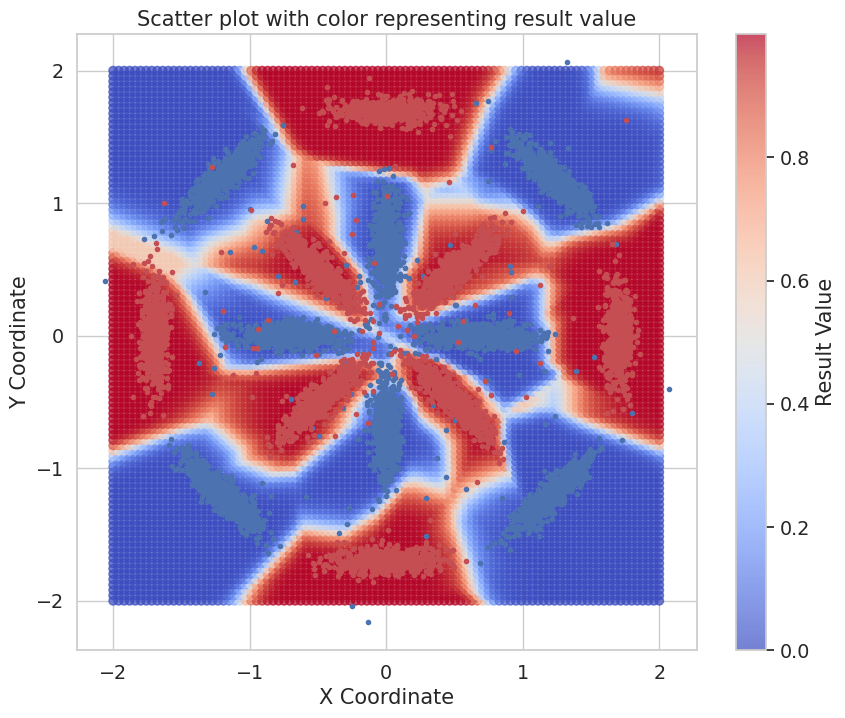

In [15]:
visualize_network(myModel, train_input, train_target)